In [1]:
%pylab inline

import seaborn as sns
import numpy as np

from sigvisa.models.ttime import tt_predict
from sigvisa.source.event import get_event, Event
from sigvisa import Sigvisa

import cPickle as pickle
from sigvisa.signals.io import load_event_station_chan, fetch_waveform

import scipy.misc

import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


In [2]:
s = Sigvisa()

sql_query = "select lebo.evid, l.time from leb_arrival l, leb_origin lebo, leb_assoc leba where lebo.orid=leba.orid and l.arid=leba.arid and l.sta=\"WRA\" and leba.phase=\"P\" and l.time between 1237680000 and 1237687200"
evids = s.sql(sql_query)

In [3]:
def load_array_waveforms(site, stime, etime, filter_str):
    elements = s.get_array_elements(site)
    waves = {}
    for element in elements:
        wave = fetch_waveform(element, "auto", stime, etime)
        waves[element] = wave.filter(filter_str)
    return waves

all_waves = load_array_waveforms("WRA", 1237681020, 1237681060,"freq_0.8_4.5;hz_10")

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


In [4]:
from sigvisa.utils.array import index_to_time, time_to_index


def back_construct_ev(sta, atime, azi, slo):
    # given a station, construct the event that generates a given P atime
    # and has a given azimuth and slowness.
    s = Sigvisa()
    elon, elat, edepth, etime = s.earthmodel.InvertDetection(sta, azi, slo, atime)
    if atime > 10 and etime < 10:
        # C code will return uninitialized mem on error, usually near zero so just test for that. 
        # this is obviously terrible of course.
        raise Exception("could not invert azi %.2f slo %.2f at refsta %s" % (azi, slo, refsta))
    
    ev = Event(lon=elon, lat=elat, mb=4.0, depth=edepth, time=etime)
    
    pred_atime = ev.time + tt_predict( ev, sta, "P", force=True)
    #print "target atime %.2f actual %.2f" % (atime, pred_atime)
    
    return ev

def azi_slowness_offsets(site, n_bins_azi, n_bins_slow, srate, refsta=None):
    # returns a set of azimuth and slowness bins, and, for each bin,
    #   a dict mapping sta -> (min_offset_idx, max_offset_idx)
    # where the offset index is relative to the reference station.
    # that is, for an event occuring within the given azimuth/slowness bin, 
    # what is the range of times it could plausibly arrive at each element station, 
    # relative to its arrival at the reference station?
    
    s = Sigvisa()
    if refsta is None:
        refsta=s.get_default_sta(site)
    
    element_stas = s.get_array_elements(site)
    dummy_atime = 1237681032.0 # doesn't actually matter since we just use relative offsets

    # slowness in secs/degree. these assume a P wave velocity,
    # but really the point is just to cover a range of incident angles.
    # the given bounds seem to be the valid ones where inversion doesn't 
    # choke. (iangle purely horizontal would be about 19, but 
    # P waves only defined for distance > 2deg...)
    slowness_bins = np.linspace(4.5, 19.1, n_bins_slow+1)
    azimuth_bins = np.linspace(0, 360, n_bins_azi+1)
    
    aligned_idxs = []    
    for i in range(n_bins_azi):
        min_azi, max_azi = azimuth_bins[i], azimuth_bins[i+1]
        aligned_idxs_azi = []
        for j in range(n_bins_slow):
            min_slow, max_slow = slowness_bins[j], slowness_bins[j+1]

            # generate four events in the corners of the azimuth/slowness bounds
            #  (note: in principle could store and reuse these for an array, just shifting the atime/origin time)
            ev11 = back_construct_ev(refsta, dummy_atime, min_azi, min_slow)
            ev12 = back_construct_ev(refsta, dummy_atime, min_azi, max_slow)
            ev21 = back_construct_ev(refsta, dummy_atime, max_azi, min_slow)
            ev22 = back_construct_ev(refsta, dummy_atime, max_azi, max_slow)
            
            aligned_idxs_bysta = {}
            for sta in element_stas:

                #if sta == refsta:
                #    # no point in modeling refsta, could only cause confusion/aliasing bugs
                #    continue
                
                # get a min and max atime for this signal at this station, 
                # given the azi/slowness bounds, by predicting the possibilities 
                # for events at the corners of the region. 
                # TODO: work out the geometry, does this really give valid bounds? 
                #        is it a problem that this doesn't necessarily partition the
                #        atime space? (i.e., adjacent azi/slowness regions might give
                #        overlapping atime bounds? I haven't thought through this at all)
                atime11 = ev11.time + tt_predict(ev11, sta, "P", force=True)
                atime12 = ev12.time + tt_predict(ev12, sta, "P", force=True)
                atime21 = ev21.time + tt_predict(ev21, sta, "P", force=True)
                atime22 = ev22.time + tt_predict(ev22, sta, "P", force=True)
                atimes = (atime11, atime12, atime21, atime22)
                min_atime = np.min(atimes)
                max_atime = np.max(atimes)
                min_idx = time_to_index(min_atime, stime=dummy_atime, srate=srate)
                max_idx = time_to_index(max_atime, stime=dummy_atime, srate=srate) + 1
                
                aligned_idxs_bysta[sta] = (min_idx, max_idx)
                
            aligned_idxs_azi.append(aligned_idxs_bysta)
        aligned_idxs.append(aligned_idxs_azi)
    return azimuth_bins, slowness_bins, aligned_idxs

ab, sb, sta_idx_dicts_by_bin = azi_slowness_offsets(site="WRA", n_bins_azi=20, 
                                                    n_bins_slow=5, srate=10.0, refsta="WB4")

In [5]:
def offset_range_union(sta_idx_dicts_by_bin):
    # given a list of dicts mapping stations to offsets (such as produced by azi_slowness_offsets),
    # return a single dict mapping 
    #   sta -> (min_offset_idx, max_offset_idx)
    # taking the union of all the bin-specific ranges. That is, return the range of 
    # offsets such that it is sufficient to compute signal likelihoods at these offsets, in order
    # to evaluate overall likelihoods for each azi/slowness bin.
    
    sta_ranges = {}
    for by_slow_bin in sta_idx_dicts_by_bin: # by azi bins
        for sta_dict_bin in by_slow_bin: 
            for sta, (min_idx, max_idx) in sta_dict_bin.items():
                if sta not in sta_ranges:
                    current_min = np.inf
                    current_max = -np.inf
                else:
                    current_min, current_max = sta_ranges[sta]
                sta_ranges[sta] = (min(current_min, min_idx), max(current_max, max_idx))
                
    return sta_ranges

sta_ranges = offset_range_union(sta_idx_dicts_by_bin)

In [6]:
print sta_ranges

{'WC1': (-6, 5), 'WC3': (-11, 9), 'WC2': (-5, 4), 'WC4': (-12, 10), 'WR6': (-20, 17), 'WR7': (-24, 20), 'WR4': (-13, 11), 'WR5': (-16, 14), 'WR2': (-9, 7), 'WR3': (-10, 9), 'WR0': (-35, 29), 'WR1': (-9, 7), 'WR8': (-28, 23), 'WR9': (-30, 25), 'WB6': (-10, 8), 'WB7': (-13, 11), 'WB4': (0, 1), 'WB5': (-6, 5), 'WB2': (-8, 7), 'WB3': (-4, 4), 'WB0': (-27, 23), 'WB1': (-11, 9), 'WB8': (-18, 15), 'WB9': (-22, 18)}


In [8]:
# hack to get the 'best' canonical station in terms of the least induced uncertainty over
# arrival times at other stations. this is probably more-or-less just the center of the array. 
element_stas = s.get_array_elements("WRA")
for refsta in element_stas:
    ab, sb, sta_idx_dicts_by_bin = azi_slowness_offsets(site="WRA", n_bins_azi=20, 
                                                    n_bins_slow=5, srate=10.0, refsta=refsta)
    sta_ranges = offset_range_union(sta_idx_dicts_by_bin)
    
    total_idx = np.sum([(mx-mn) for (mn, mx) in sta_ranges.values()])
    print refsta, total_idx

WB0 1327
WB1 713
WB2 645
WB3 616
WB4 640
WB5 700
WB6 796
WB7 855
WB8 1006
WB9 1148
WC1 677
WC2 596
WC3 654
WC4 750
WR0 1291
WR1 688
WR2 624
WR3 619


KeyboardInterrupt: 

In [9]:
def build_signalproc_graph(sta_placeholders, 
                           sta_offset_ranges, 
                           refsta,
                           tmpl_sidx,
                           tmpl_npts,
                           iid_std="auto"):
    # given a dict mapping
    #  sta -> tf placeholder
    # representing a signal window at each station, and a range of offsets at each station
    # (as given by offset_range_union), return a dict mapping 
    #  sta -> tf Tensor
    # where each station is represented by a tensor of length (max_offset-min_offset)
    # with values giving the proxy likelihood of that station under each offset from the refsta.
    
    
    refsta_signal = sta_placeholders[refsta]
    template = tf.slice(refsta_signal, (tmpl_sidx,), (tmpl_npts,))
    
    if iid_std == "auto":
        mean, var = tf.nn.moments(refsta_signal, [0])
        iid_std = tf.sqrt(var)
    
    # normalize the data and template so we can assume std=1 to simplify somewhat
    norm_tmpl = template / iid_std
    
    sta_lps = {}
    for sta in sta_placeholders.keys():
        if sta == refsta:
            continue
        
        sta_signal = sta_placeholders[sta]
        min_idx, max_idx = sta_offset_ranges[sta]
        norm_data = sta_signal / iid_std

        # compute base logp of the unmodified signal
        #logZ = npts_data * .5 * tf.log(2*np.pi*tf.square(iid_std))
        #global_lp = -.5 * tf.reduce_sum(tf.square(norm_data)) - logZ

        # logp for each alignment is an adjustment to the base lp
        # TODO can probably frame this more efficiently in TF vocabulary,
        # this is a hacky port from hacky numpy code
        lps = []
        for idx in range(min_idx, max_idx):
            window = tf.slice(norm_data, (tmpl_sidx + idx,), (tmpl_npts,))
            base = -.5 * tf.reduce_sum(tf.square(window))
            diff = -.5 * tf.reduce_sum(tf.square(window - norm_tmpl))
            lps.append(-base + diff ) 
            
        sta_lps[sta] = lps
    return sta_lps


In [10]:
def reduce_logsumexp(x, axis=None, **kwargs):
    shift = tf.reduce_max(x, axis=axis, **kwargs)

    # expand dims to make sure we broadcast the shift correctly
    if axis is not None:
        broadcast_shift = tf.expand_dims(shift, axis)
    else:
        broadcast_shift = shift

    return tf.log(tf.reduce_sum(tf.exp(x - broadcast_shift), axis=axis, **kwargs)) + shift


def build_azibins_graph(sta_lps, sta_offsets, sta_idx_dicts_by_bin):
    # given the likelihood Tensors output by build_signalproc_graph,
    # and an array of dicts output from azi_slowness_offsets (mapping azi/slowness to station indices),
    # return a tf Tensor of shape (n_azi, n_slowness) giving scores for each bin, 
    # logsumexp'ing over indices at each station, and summing over stations.
    
    bin_lps = []
    for i, azi_bin_dicts in enumerate(sta_idx_dicts_by_bin):
        bin_lps_row = []
        print "azi bin", i
        for j, bin_dict in enumerate(azi_bin_dicts):
            sta_logps = []
            rel_idxs = []
            
            for sta, local_sta_lps in sta_lps.items():
                
                bin_min_idx, bin_max_idx = bin_dict[sta]
                global_min_idx, global_max_idx = sta_offsets[sta]
                rel_min_idx = bin_min_idx - global_min_idx
                rel_max_idx = bin_max_idx - global_min_idx
                rel_idx = int(np.floor(   (rel_min_idx + rel_max_idx)/2.0 ))
                
                
                sta_logp = local_sta_lps[rel_idx]
                
                """
                n_candidates = rel_max_idx-rel_min_idx
                candidate_lps = local_sta_lps[rel_min_idx:rel_max_idx]
                #tf.slice(local_sta_lps, (rel_min_idx,), (n_candidates,))
                
                log_n_candidates = np.log(n_candidates)
                sta_logp = tf.reduce_max(candidate_lps) #reduce_logsumexp(candidate_lps) - log_n_candidates
                """
                
                sta_logps.append(sta_logp)
                
            bin_logp = tf.reduce_sum(tf.stack(sta_logps))
            bin_lps_row.append(bin_logp)
        bin_lps.append(tf.stack(bin_lps_row))
    bin_lps = tf.stack(bin_lps)
    return bin_lps

In [11]:
site="WRA"
signals=all_waves
n_bins_azi=180
n_bins_slow=80
template_len_s = 6.0
max_offset_s = 4.5
output_hz=1.0

#def run_azislow_proposal(site, signals, 
#                         n_bins_azi, n_bins_slow, 
#                         template_len_s = 10.0,
#                         max_offset_s = 4.0,
#                         output_hz=1.0):
if True:
    # given a site and a dict of signal Waveforms at each station.
    # call azi_slowness_offsets to precompute the offsets at each station
    # set up the TF graph (including placeholders) to map from a signal window at each station to an azi/slowness posterior
    # then loop through the signal at intervals of output_hz, and drive a TF session to evaluate the posterior
    # return an array of size [T, n_azi_bins, n_bins_slow] where T is the number of timesteps (T = len(signals) * output_hz)
    
    s = Sigvisa()
    refsta = "WC2" #s.get_default_sta(site)
    srate = signals[refsta]["srate"]
    total_npts = signals[refsta]["npts"]
    
    
    # at each target, feed a window equal to the template
    # length plus some padding on each side
    target_s = template_len_s + 2 * max_offset_s
    target_npts = int(srate * target_s)
    # at the refsta, the template would start at this fixed offset
    # (all other stations are computed relative to this)
    template_sidx = int(max_offset_s * srate)
    template_npts = int(template_len_s * srate)
    
    ab, sb, sta_idx_dicts_by_bin = azi_slowness_offsets(site=site, 
                                                        n_bins_azi=n_bins_azi, 
                                                        n_bins_slow=n_bins_slow, 
                                                        srate=srate, 
                                                        refsta=refsta)
    sta_offset_ranges = offset_range_union(sta_idx_dicts_by_bin)
    sta_placeholders = {sta: tf.placeholder(shape=(target_npts,), dtype=np.float32) \
                        for sta in sta_offset_ranges.keys()}
    
    sta_lps = build_signalproc_graph(sta_placeholders, sta_offset_ranges, refsta, 
                                     template_sidx, template_npts, iid_std="auto")
    bin_lps = build_azibins_graph(sta_lps, sta_offset_ranges, sta_idx_dicts_by_bin)
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    
    tick_idx = int(srate/output_hz)
    posteriors = []
    
        
    #return posteriors



azi bin 0
azi bin 1
azi bin 2
azi bin 3
azi bin 4
azi bin 5
azi bin 6
azi bin 7
azi bin 8
azi bin 9
azi bin 10
azi bin 11
azi bin 12
azi bin 13
azi bin 14
azi bin 15
azi bin 16
azi bin 17
azi bin 18
azi bin 19
azi bin 20
azi bin 21
azi bin 22
azi bin 23
azi bin 24
azi bin 25
azi bin 26
azi bin 27
azi bin 28
azi bin 29
azi bin 30
azi bin 31
azi bin 32
azi bin 33
azi bin 34
azi bin 35
azi bin 36
azi bin 37
azi bin 38
azi bin 39
azi bin 40
azi bin 41
azi bin 42
azi bin 43
azi bin 44
azi bin 45
azi bin 46
azi bin 47
azi bin 48
azi bin 49
azi bin 50
azi bin 51
azi bin 52
azi bin 53
azi bin 54
azi bin 55
azi bin 56
azi bin 57
azi bin 58
azi bin 59
azi bin 60
azi bin 61
azi bin 62
azi bin 63
azi bin 64
azi bin 65
azi bin 66
azi bin 67
azi bin 68
azi bin 69
azi bin 70
azi bin 71
azi bin 72
azi bin 73
azi bin 74
azi bin 75
azi bin 76
azi bin 77
azi bin 78
azi bin 79
azi bin 80
azi bin 81
azi bin 82
azi bin 83
azi bin 84
azi bin 85
azi bin 86
azi bin 87
azi bin 88
azi bin 89
azi bin 90
azi bin 9

In [12]:
signals = all_waves
posteriors = []
total_npts = signals[refsta]["npts"]
for idx in range(0, total_npts-target_npts, tick_idx):
    signal_slices = {sta_placeholders[sta]: signals[sta].data[idx : idx + target_npts] for sta in sta_placeholders.keys()}
    bin_posterior = sess.run(bin_lps, feed_dict = signal_slices)
    print "got posterior for slice at %.1fs" % ( idx/float(srate))
    posteriors.append(bin_posterior)

got posterior for slice at 0.0s
got posterior for slice at 1.0s
got posterior for slice at 2.0s
got posterior for slice at 3.0s
got posterior for slice at 4.0s
got posterior for slice at 5.0s
got posterior for slice at 6.0s
got posterior for slice at 7.0s
got posterior for slice at 8.0s
got posterior for slice at 9.0s
got posterior for slice at 10.0s
got posterior for slice at 11.0s
got posterior for slice at 12.0s
got posterior for slice at 13.0s
got posterior for slice at 14.0s
got posterior for slice at 15.0s
got posterior for slice at 16.0s
got posterior for slice at 17.0s
got posterior for slice at 18.0s
got posterior for slice at 19.0s
got posterior for slice at 20.0s
got posterior for slice at 21.0s
got posterior for slice at 22.0s
got posterior for slice at 23.0s
got posterior for slice at 24.0s
got posterior for slice at 25.0s
got posterior for slice at 26.0s
got posterior for slice at 27.0s
got posterior for slice at 28.0s
got posterior for slice at 29.0s
got posterior for sl

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual


%matplotlib inline

def pltposterior(t):
    pt = posteriors[t]
    
    best_azi =  np.argmax(pt) / pt.shape[1]
    best_slo = np.argmax(pt) - best_azi * pt.shape[1]

    print "max %d %d azi %.1f-%.1f slo %.1f-%.1f" % (best_azi, best_slo, ab[best_azi], ab[best_azi+1], sb[best_slo], sb[best_slo+1])
    
    plt.imshow( np.exp(   (pt - np.max(pt)    )/200.0   ))
    plt.show()

    
interact(pltposterior, t = (0, len(posteriors)-1, 1))

<function __main__.pltposterior>

STATUS:
- can walk a signal and generate a posterior on azi/slowness at each time
- posterior is not totally accurate but seems pretty good, has the right qualitative properties, is fast enough to preprocess all signals. (will want to cache though). 


TODO:
- work out math for Hough bin score. what is prob of observed data (this azi/slow posterior, and indirectly the signals) given observation? 
- implement in basic code. for some small number of stations (like in previous ipy notebook!), show we improve proposals by feeding in azi information. 



ev evid 5288041.0, loc 127.20 E 2.81 N, depth 0.0km, time 1237680436.1, mb 3.2, natural source
true azi 342.00 slo 9.97
best range 338.0 340.0 10.5225 10.705

ev evid 5269697.0, loc 172.99 W 16.07 S, depth 0.0km, time 1237680495.7, mb 4.2, natural source
true azi 94.57 slo 7.57
best range 90.0 92.0 7.2375 7.42

ev evid 5270714.0, loc 174.79 W 23.51 S, depth 0.0km, time 1237680753.6, mb 4.2, natural source
true azi 103.94 slo 7.78
best range 98.0 100.0 7.9675 8.15

ev evid 5269733.0, loc 174.86 W 23.22 S, depth 0.0km, time 1237681509.4, mb 4.1, natural source
true azi 103.54 slo 7.78
best range 94.0 96.0 7.9675 8.15

ev evid 5269769.0, loc 132.87 E 0.46 S, depth 0.0km, time 1237682761.1, mb 4.2, natural source
true azi 355.56 slo 10.94
best range 354.0 356.0 11.435 11.6175

ev evid 5288032.0, loc 128.30 E 0.50 S, depth 0.0km, time 1237683622.2, mb 3.6, natural source
true azi 342.27 slo 10.86
best range 340.0 342.0 11.435 11.6175

ev evid 5269822.0, loc 146.57 E 5.61 S, depth 65.5km, ti

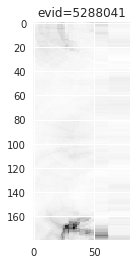

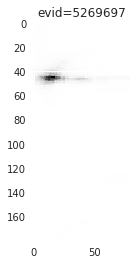

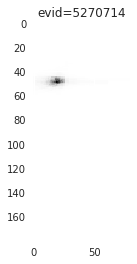

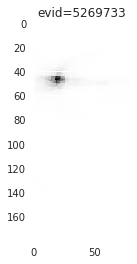

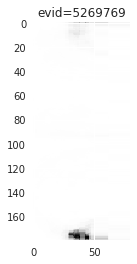

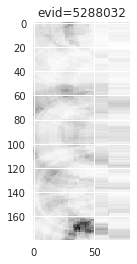

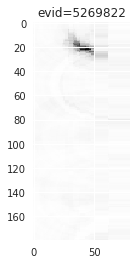

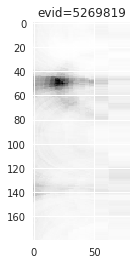

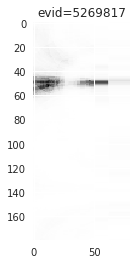

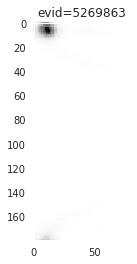

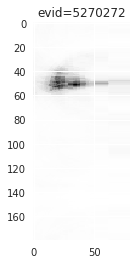

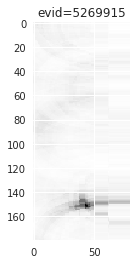

In [34]:
for evid, atime in evids:
    
    ev = get_event(evid=evid)
    
    pred_atime = ev.time + tt_predict(ev, "WR1", "P", force=True)
    all_waves = load_array_waveforms("WRA", pred_atime-10, pred_atime+30,"freq_0.8_4.5;hz_10")

    target_s = template_len_s + 2 * max_offset_s
    target_npts = int(srate * target_s)
    # at the refsta, the template would start at this fixed offset
    # (all other stations are computed relative to this)
    template_sidx = int(max_offset_s * srate)
    template_npts = int(template_len_s * srate)
    
    slice_idx = int(10*(30 - max_offset_s))
    
    signal_slices = {sta_placeholders[sta]: all_waves[sta].data[slice_idx : slice_idx + target_npts]\
                     for sta in sta_placeholders.keys()}
    
    bin_posterior = sess.run(bin_lps, feed_dict = signal_slices)
    
    s = Sigvisa()
    siteid = s.earthmodel.site_info("WRA", 0)[6]
    true_az = s.earthmodel.ArrivalAzimuth(ev.lon, ev.lat, "WRA", ev.time)
    true_slo = s.earthmodel.ArrivalSlowness(ev.lon, ev.lat, ev.depth, 0, "WRA", ev.time)
    
    plt.figure()
    plt.title("evid=%d" % ev.evid)
    plt.imshow(np.exp( (bin_posterior  -np.max(bin_posterior)) / 200.0))
    pt = bin_posterior
    best_azi =  np.argmax(pt) / pt.shape[1]
    best_slo = np.argmax(pt) - best_azi * pt.shape[1]

    print "ev", ev
    print "true azi %.2f slo %.2f" % (true_az, true_slo)
    print "best range", ab[best_azi], ab[best_azi+1], sb[best_slo], sb[best_slo+1]
    print
    
    